# Standard Pipeline – Training & Evaluation

Baseline training using the standard preprocessing pipeline:
- clean data, engineer features, winsorize
- train Logistic Regression and Random Forest
- cross-validate, evaluate on test set, save metrics and models

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import joblib

sys.path.append(os.path.abspath(".."))

from src.config import RANDOM_STATE, N_SPLITS
from src.data_prep import (
    load_raw_data,
    apply_strict_clinical_cleaning,
    feature_engineering,
    apply_standard_winsorization
)
from src.preprocessing import build_train_test_split, build_standard_preprocessor
from src.modeling import (
    train_logistic_regression,
    train_random_forest,
    cross_validate_model,
    evaluate_on_test,
)
from src.visualization import plot_roc_curve, plot_pr_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve

os.makedirs("../models", exist_ok=True)

In [2]:
# Data Preparation
df = load_raw_data("../data/raw/cardio_train.csv")
df = apply_strict_clinical_cleaning(df)
df = feature_engineering(df)
df = apply_standard_winsorization(df)

df.to_csv("../data/processed/cardio_processed.csv", index=False)

In [3]:
# Train
X_train, X_test, y_train, y_test = build_train_test_split(df, random_state=RANDOM_STATE)

In [4]:
# Preprocessor and Model Training
preprocessor = build_standard_preprocessor()

lr_pipe_cv = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, penalty="l2", random_state=RANDOM_STATE)),
])

rf_pipe_cv = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE,
    )),
])

In [5]:
# Cross-validation
cv_lr = cross_validate_model(lr_pipe_cv, X_train, y_train, RANDOM_STATE, N_SPLITS)
cv_rf = cross_validate_model(rf_pipe_cv, X_train, y_train, RANDOM_STATE, N_SPLITS)

pd.DataFrame([cv_lr]).to_csv("../reports/tables/cv_lr_standard.csv", index=False)
pd.DataFrame([cv_rf]).to_csv("../reports/tables/cv_rf_standard.csv", index=False)

df_cv = pd.DataFrame([cv_lr, cv_rf], index=["Logistic Regression", "Random Forest"])
df_cv = df_cv.round(4)
df_cv

,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
Logistic Regression,0.7933,0.0031,0.7723,0.0040
Random Forest,0.7980,0.0033,0.7788,0.0041


In [6]:
# Train
lr_pipe, lr_params = train_logistic_regression(preprocessor, X_train, y_train, RANDOM_STATE)
rf_pipe, rf_params = train_random_forest(preprocessor, X_train, y_train, RANDOM_STATE)

In [7]:
# Test evaluation
test_lr = evaluate_on_test(lr_pipe, X_test, y_test)
test_rf = evaluate_on_test(rf_pipe, X_test, y_test)

pd.DataFrame([test_lr]).to_csv("../reports/tables/test_lr_standard.csv", index=False)
pd.DataFrame([test_rf]).to_csv("../reports/tables/test_rf_standard.csv", index=False)

df_test = pd.DataFrame([test_lr, test_rf], index=["Logistic Regression", "Random Forest"])
df_test = df_test.round(4)
df_test

,roc_auc,pr_auc
Logistic Regression,0.7861,0.7679
Random Forest,0.7894,0.7734


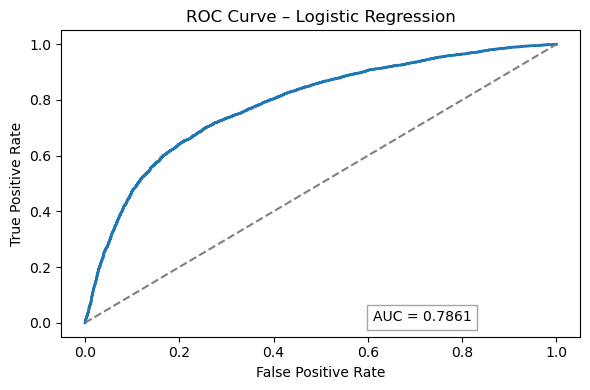

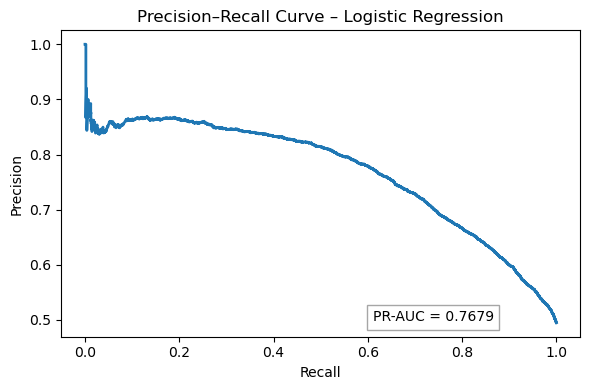

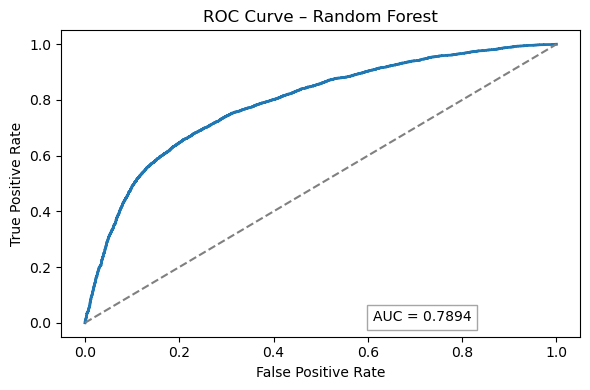

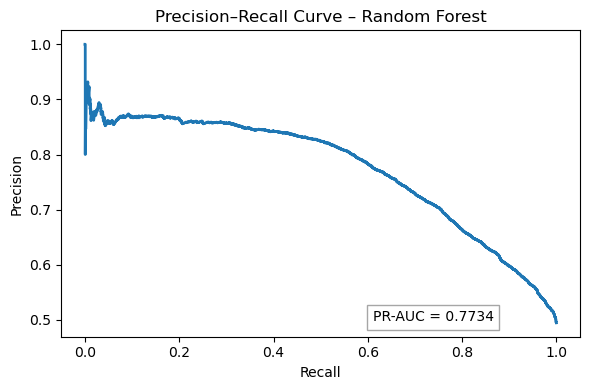

In [8]:
# Visualization
# Logistic Regression
y_prob_lr = lr_pipe.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)

fig_roc_lr = plot_roc_curve(fpr_lr, tpr_lr, test_lr["roc_auc"], "Logistic Regression")
fig_pr_lr  = plot_pr_curve(precision_lr, recall_lr, test_lr["pr_auc"], "Logistic Regression")

fig_roc_lr.savefig("../reports/figures/roc_lr_standard.png", dpi=300)
fig_pr_lr.savefig("../reports/figures/pr_lr_standard.png", dpi=300)

# Random Forest
y_prob_rf = rf_pipe.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)

fig_roc_rf = plot_roc_curve(fpr_rf, tpr_rf, test_rf["roc_auc"], "Random Forest")
fig_pr_rf  = plot_pr_curve(precision_rf, recall_rf, test_rf["pr_auc"], "Random Forest")

fig_roc_rf.savefig("../reports/figures/roc_rf_standard.png", dpi=300)
fig_pr_rf.savefig("../reports/figures/pr_rf_standard.png", dpi=300)

In [9]:
# Save Models and probabilities
joblib.dump(lr_pipe, "../models/logistic_regression_standard.joblib")
joblib.dump(rf_pipe, "../models/random_forest_standard.joblib")

np.save("../data/processed/y_prob_lr.npy", y_prob_lr)
np.save("../data/processed/y_prob_rf.npy", y_prob_rf)